In [3]:
import pims
import torch as tr
import random
import yaml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from vre.representations import build_representations_from_cfg, SemanticMapper
from vre.utils import get_project_root, collage_fn
from vre import ReprOut

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
video = pims.Video(get_project_root() / "resources/test_video.mp4")
video.file = get_project_root() / "resources/test_video.mp4"
print(video)

<FramesSequenceND>
Axes: 3
Axis 'x' size: 1280
Axis 'y' size: 720
Axis 't' size: 5395
Pixel Datatype: uint8


In [5]:

"""setup all representations we want to use, including one representation per device"""
device = "cuda" if tr.cuda.is_available() else "cpu"
all_representations_dict = yaml.safe_load(f"""
rgb:
  type: default/rgb
  dependencies: []
  parameters: {{}}

mask2former_coco_47429163_0:
  type: semantic-segmentation/mask2former
  dependencies: []
  parameters:
    model_id: "47429163_0"
    semantic_argmax_only: True
  batch_size: 1
  device: {device}

mask2former_mapillary_49189528_0:
  type: semantic-segmentation/mask2former
  dependencies: []
  parameters:
    model_id: "49189528_0"
    semantic_argmax_only: True
  batch_size: 1
  device: {device}

# depth_marigold:
#   type: depth/marigold
#   dependencies: []
#   parameters:
#     variant: marigold-lcm-v1-0
#     denoising_steps: 4
#     ensemble_size: 1
#     processing_resolution: 768
#   batch_size: 1
#   device: {device}
""")

print(video.shape, video.frame_rate)
start_frame = 1000
end_frame = start_frame + 1

representations = build_representations_from_cfg(all_representations_dict)
representations["mask2former_mapillary_49189528_0"].vre_setup() # TODO: get rid of; it's only for viz
representations["mask2former_coco_47429163_0"].vre_setup() # TODO: get rid of; it's only for viz
# representations["depth_marigold"].vre_setup() # TODO: get rid of; it's only for viz

[2024-10-15T16:11:19 VRE-DEBUG] Doing topological sort... (build_representations.py:build_representations_from_cfg:96)
[2024-10-15T16:11:19 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: mask2former_mapillary_49189528_0) (build_representations.py:build_representation_from_cfg:74)


(5395, 720, 1280, 3) 29.97


[2024-10-15T16:11:21 VRE-INFO] Explicit device provided: cuda. This device will be used at vre.run() (build_representations.py:build_representation_from_cfg:81)
[2024-10-15T16:11:21 VRE-INFO] Explicit batch size 1 provided to mask2former_mapillary_49189528_0. (build_representations.py:build_representation_from_cfg:84)
[2024-10-15T16:11:21 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: mask2former_coco_47429163_0) (build_representations.py:build_representation_from_cfg:74)
[2024-10-15T16:11:21 VRE-INFO] Explicit device provided: cuda. This device will be used at vre.run() (build_representations.py:build_representation_from_cfg:81)
[2024-10-15T16:11:21 VRE-INFO] Explicit batch size 1 provided to mask2former_coco_47429163_0. (build_representations.py:build_representation_from_cfg:84)
[2024-10-15T16:11:21 VRE-INFO] Building 'default/rgb' (vre name: rgb) (build_representations.py:build_representation_from_cfg:74)
[2024-10-15T16:11:21 VRE-DEBUG] Loading weights from '/home

In [6]:
mapillary_classes = ["Bird", "Ground Animal", "Curb", "Fence", "Guard Rail", "Barrier", "Wall", "Bike Lane",
                    "Crosswalk - Plain", "Curb Cut", "Parking", "Pedestrian Area", "Rail Track", "Road",
                    "Service Lane", "Sidewalk", "Bridge", "Building", "Tunnel", "Person", "Bicyclist",
                    "Motorcyclist", "Other Rider", "Lane Marking - Crosswalk", "Lane Marking - General",
                    "Mountain", "Sand", "Sky", "Snow", "Terrain", "Vegetation", "Water", "Banner", "Bench",
                    "Bike Rack", "Billboard", "Catch Basin", "CCTV Camera", "Fire Hydrant", "Junction Box",
                    "Mailbox", "Manhole", "Phone Booth", "Pothole", "Street Light", "Pole", "Traffic Sign Frame",
                    "Utility Pole", "Traffic Light", "Traffic Sign (Back)", "Traffic Sign (Front)", "Trash Can",
                    "Bicycle", "Boat", "Bus", "Car", "Caravan", "Motorcycle", "On Rails", "Other Vehicle", "Trailer",
                    "Truck", "Wheeled Slow", "Car Mount", "Ego Vehicle"]
mapillary_mapping = {
        "land": ["Terrain", "Sand", "Snow"],
        "forest": ["Vegetation"],
        "residential": ["Building", "Utility Pole", "Pole", "Fence", "Wall", "Manhole", "Street Light", "Curb",
                        "Guard Rail", "Caravan", "Junction Box", "Traffic Sign (Front)", "Billboard", "Banner",
                        "Mailbox", "Traffic Sign (Back)", "Bench", "Fire Hydrant", "Trash Can", "CCTV Camera",
                        "Traffic Light", "Barrier", "Rail Track", "Phone Booth", "Curb Cut", "Traffic Sign Frame",
                        "Bike Rack"],
        "road": ["Road", "Lane Marking - General", "Sidewalk", "Bridge", "Other Vehicle", "Motorcyclist", "Pothole",
                 "Catch Basin", "Car Mount", "Tunnel", "Parking", "Service Lane", "Lane Marking - Crosswalk",
                 "Pedestrian Area", "On Rails", "Bike Lane", "Crosswalk - Plain"],
        "little-objects": ["Car", "Person", "Truck", "Boat", "Wheeled Slow", "Trailer", "Ground Animal", "Bicycle",
                           "Motorcycle", "Bird", "Bus", "Ego Vehicle", "Bicyclist", "Other Rider"],
        "water": ["Water"],
        "sky": ["Sky"],
        "hill": ["Mountain"]
    }
color_map = [[0, 255, 0], [0, 127, 0], [255, 255, 0], [255, 255, 255],
             [255, 0, 0], [0, 0, 255], [0, 255, 255], [127, 127, 63]]
mapper = SemanticMapper(original_classes=[mapillary_classes], mapping=[mapillary_mapping],
                        color_map=color_map, name="mapilary_to_dronescapes",
                        dependencies=[representations["mask2former_mapillary_49189528_0"]])
representations[mapper.name] = mapper

In [7]:
coco_mapping = {
    "land": ["grass-merged", "dirt-merged", "sand", "gravel", "flower", "playingfield", "snow", "platform"],
    "forest": ["tree-merged"],
    "residential": ["building-other-merged", "house", "roof", "fence-merged", "wall-other-merged", "wall-brick",
                    "rock-merged", "tent", "bridge", "bench", "window-other", "fire hydrant", "traffic light",
                    "umbrella", "wall-stone", "clock", "chair", "sports ball",
                    "floor-other-merged", "floor-wood", "stop sign", "door-stuff", "banner", "light", "net",
                    "surfboard", "frisbee", "rug-merged", "potted plant", "parking meter"],
    "road": ["road", "railroad", "pavement-merged", "stairs"],
    "little-objects": ["truck", "car", "boat", "horse", "person", "train", "elephant", "bus", "bird", "sheep", "cow",
                       "motorcycle", "dog", "bicycle", "airplane", "kite"],
    "water": ["river", "water-other", "sea"],
    "sky": ["sky-other-merged"],
    "hill": ["mountain-merged"]
}
coco_classes = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light",
                "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
                "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
                "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
                "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
                "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
                "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard",
                "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase",
                "scissors", "teddy bear", "hair drier", "toothbrush", "banner", "blanket", "bridge", "cardboard",
                "counter", "curtain", "door-stuff", "floor-wood", "flower", "fruit", "gravel", "house", "light",
                "mirror-stuff", "net", "pillow", "platform", "playingfield", "railroad", "river", "road", "roof",
                "sand", "sea", "shelf", "snow", "stairs", "tent", "towel", "wall-brick", "wall-stone", "wall-tile",
                "wall-wood", "water-other", "window-blind", "window-other", "tree-merged", "fence-merged",
                "ceiling-merged", "sky-other-merged", "cabinet-merged", "table-merged", "floor-other-merged",
                "pavement-merged", "mountain-merged", "grass-merged", "dirt-merged", "paper-merged",
                "food-other-merged", "building-other-merged", "rock-merged", "wall-other-merged", "rug-merged"]

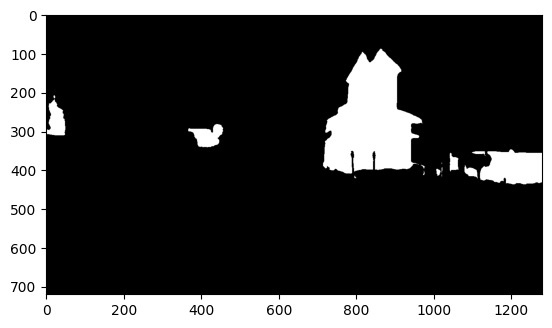

In [8]:
mapping1 = {
    "man-made-construction": ["Building"],
    "others": [x for x in mapillary_classes if x != "Building"]
}
mapping2 = {
    "man-made-construction": ["building-other-merged", "house", "roof"],
    "others": [x for x in coco_classes if x not in ["building-other-merged", "house", "roof"]]
}
color_map = [[255, 255, 255], [0, 0, 0]]

class SemanticMultiMapper(SemanticMapper):
    def merge(self, data):
        return ((data[0] + data[1]) != 0).astype(np.uint8)

mapper2 = SemanticMultiMapper(original_classes=[mapillary_classes, coco_classes], mapping=[mapping1, mapping2],
                              color_map=color_map, name="buildings_only",
                              dependencies=[representations["mask2former_mapillary_49189528_0"],
                                            representations["mask2former_coco_47429163_0"]])
representations[mapper2.name] = mapper2
_ixs = [0]
res = mapper2.vre_make(video, _ixs, Path.cwd() / "data")
res_img = mapper2.make_images(video[_ixs],res)[0]

plt.imshow(res_img)

[2024-10-15T16:11:30 VRE-DEBUG] Loading weights from '/home/mihai/code/ml/video-representations-extractor/resources/weights/semantic_segmentation/mask2former/49189528_0.ckpt' (resources.py:vre_load_weights:73)
[2024-10-15T16:11:36 VRE-DEBUG] Loading weights from '/home/mihai/code/ml/video-representations-extractor/resources/weights/semantic_segmentation/mask2former/47429163_0.ckpt' (resources.py:vre_load_weights:73)


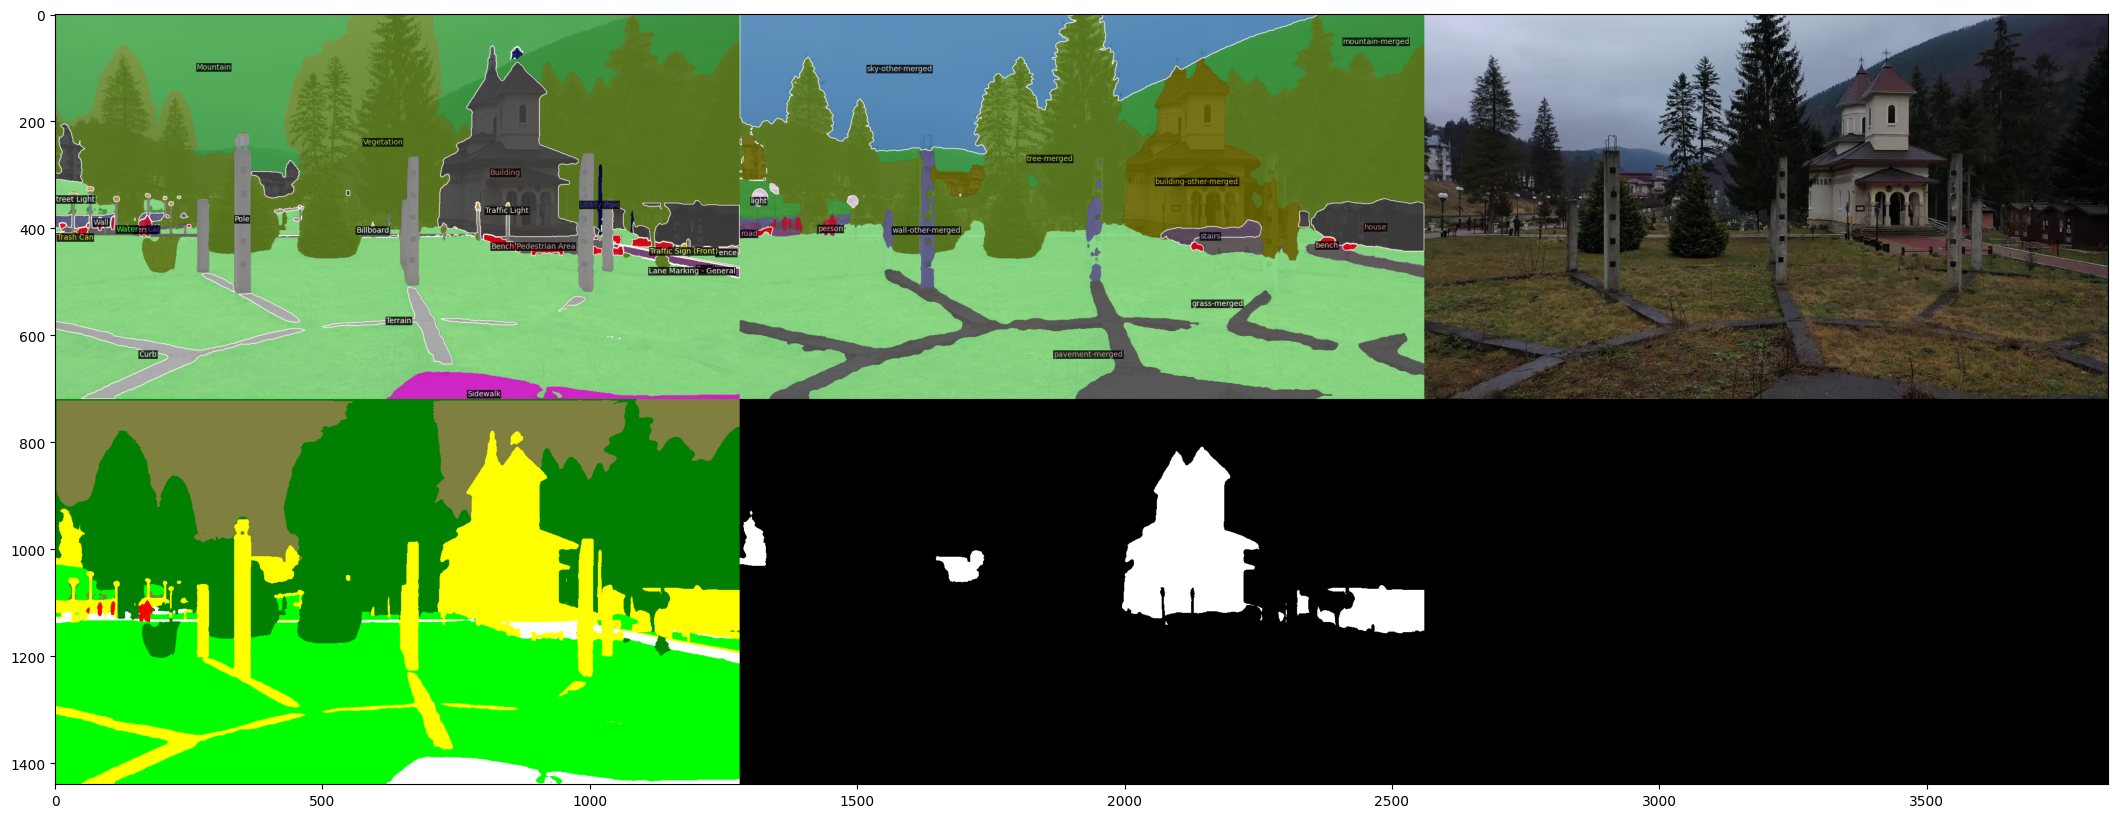

In [9]:
# representations["mask2former_mapillary_49189528_0"].vre_setup() # TODO: get rid of; it's only for viz
# representations["mask2former_coco_47429163_0"].vre_setup() # TODO: get rid of; it's only for viz
imgs = []
ixs = sorted([int(x.stem) for x in (Path.cwd() / "data/rgb/npy").iterdir() if int(x.stem) <= len(video)])
# _ixs = [random.choice(ixs)]
# _ixs = [830]
_ixs = [0]
for k, r in representations.items():
    r.vre_setup() if hasattr(r, "vre_setup") else None
    res = r.vre_make(video, _ixs, Path.cwd() / "data")
    res_img = r.make_images(video[_ixs], res)[0]
    r.vre_free() if hasattr(r, "vre_free") else None
    imgs.append(res_img)
plt.figure(figsize=(40, 10))
plt.imshow(collage_fn(imgs))
